# Working with other models from tf.contrib.learn

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

## 1. Load and prepare the data

In [2]:
current_dir = os.getcwd()
dataset_path = os.path.join(os.getcwd(), os.pardir, 'data', 'diamond_prices_original.csv')
diamonds = pd.read_csv(dataset_path)
TARGET = 'price'

In [3]:
## Separating into training and testing: the objects we got back are pandas DataFrames.
X_train, X_val, y_train, y_val = train_test_split(diamonds.drop(TARGET, axis=1),
                                                  diamonds[TARGET],
                                                  train_size=0.9,
                                                  random_state=60)

In [4]:
diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## 2. Write one or more dataset importing functions

In [5]:
BATCH_SIZE = 128
N_EPOCHS = 400
## Training input function
input_fn_train = tf.estimator.inputs.pandas_input_fn(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    num_epochs=N_EPOCHS,
    shuffle = True,
    target_column=TARGET)

## Validation input function
input_fn_val = tf.estimator.inputs.pandas_input_fn(
    x=X_val,
    y=y_val,
    num_epochs=1,
    shuffle = False,
    target_column=TARGET)

## 3. Define the features for the "deep" part of the model (DNN)

Here we commonly use the numerical features or other dense columns in our data.

In [6]:
numerical_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_cols = ['cut', 'color', 'clarity']

unique_values = {col: list(diamonds[col].unique()) for col in categorical_cols}

cut = tf.feature_column.categorical_column_with_vocabulary_list('cut', 
                                                                vocabulary_list=list(diamonds['cut'].unique()))


deep_columns = [tf.feature_column.numeric_column(col) for col in numerical_cols]
deep_columns = deep_columns + [tf.feature_column.indicator_column(cut)]

## 4. Define the features for the "wide" part of the model (linear model)

You can create interactions that result in sparse columns in this step.

In [7]:
clarity = tf.feature_column.categorical_column_with_vocabulary_list('clarity', 
                                                                vocabulary_list=list(diamonds['clarity'].unique()))

color = tf.feature_column.categorical_column_with_vocabulary_list('color', 
                                                                vocabulary_list=list(diamonds['color'].unique()))

# Creating the 3 interaction features
# tf.feature_column.crossed_column: Returns a column for performing crosses of categorical features.
cut_x_color = tf.feature_column.crossed_column(['cut', 'color'], hash_bucket_size=5*7)
cut_x_clarity = tf.feature_column.crossed_column(['cut', 'clarity'], hash_bucket_size=5*8)
color_x_clarity = tf.feature_column.crossed_column(['color', 'clarity'], hash_bucket_size=7*8)

wide_columns = [color, clarity, cut_x_color, cut_x_clarity, color_x_clarity]

## 5. Instantiate the DNNLinearCombinedRegressor Estimator

In [8]:
combined_model = tf.estimator.DNNLinearCombinedRegressor(
    model_dir='./wide_and_deep_model',
    linear_feature_columns=wide_columns,
    dnn_feature_columns=deep_columns,
    dnn_hidden_units=[64, 32, 16, 8])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './wide_and_deep_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023D9F48E400>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## 5. Train the model

In [9]:
combined_model.train(input_fn=input_fn_train)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./wide_and_deep_model\model.ckpt.
INFO:tensorflow:loss = 4.14569e+09, step = 1
INFO:tensorflow:global_step/sec: 190.763
INFO:tensorflow:loss = 3.48952e+09, step = 101 (0.527 sec)
INFO:tensorflow:global_step/sec: 314.002
INFO:tensorflow:loss = 3.84351e+09, step = 201 (0.319 sec)
INFO:tensorflow:global_step/sec: 287.781
INFO:tensorflow:loss = 4.21204e+09, step = 301 (0.348 sec)
INFO:tensorflow:global_step/sec: 331.264
INFO:tensorflow:loss = 3.55313e+09, step = 401 (0.301 sec)
INFO:tensorflow:global_step/sec: 260.996
INFO:tensorflow:loss = 3.73544e+09, step = 501 (0.384 sec)
INFO:tensorflow:global_step/sec: 281.039
INFO:tensorflow:loss = 2.89769e+09, step = 601 (0.356 sec)
INFO:tensorflow:global_step/sec: 239.653
INFO:tensorflow:loss = 4.20192e+09, step = 701 (0.418 sec)
INFO:tensorflow:global_step/sec: 286.951
INFO:tensorflow:loss = 4.17243e+09, step = 801 (0.353 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 335.641
INFO:tensorflow:loss = 2.17211e+09, step = 8101 (0.300 sec)
INFO:tensorflow:global_step/sec: 320.156
INFO:tensorflow:loss = 1.46872e+09, step = 8201 (0.312 sec)
INFO:tensorflow:global_step/sec: 315.582
INFO:tensorflow:loss = 1.50949e+09, step = 8301 (0.315 sec)
INFO:tensorflow:global_step/sec: 235.452
INFO:tensorflow:loss = 1.51867e+09, step = 8401 (0.429 sec)
INFO:tensorflow:global_step/sec: 179.71
INFO:tensorflow:loss = 1.79586e+09, step = 8501 (0.556 sec)
INFO:tensorflow:global_step/sec: 160.549
INFO:tensorflow:loss = 2.0394e+09, step = 8601 (0.620 sec)
INFO:tensorflow:global_step/sec: 198.588
INFO:tensorflow:loss = 1.80012e+09, step = 8701 (0.505 sec)
INFO:tensorflow:global_step/sec: 174.519
INFO:tensorflow:loss = 1.67199e+09, step = 8801 (0.574 sec)
INFO:tensorflow:global_step/sec: 193.418
INFO:tensorflow:loss = 1.86553e+09, step = 8901 (0.518 sec)
INFO:tensorflow:global_step/sec: 197.587
INFO:tensorflow:loss = 2.56739e+09, step = 9001 (0.5

INFO:tensorflow:global_step/sec: 197.063
INFO:tensorflow:loss = 2.10451e+09, step = 16201 (0.505 sec)
INFO:tensorflow:global_step/sec: 194.547
INFO:tensorflow:loss = 2.09912e+09, step = 16301 (0.515 sec)
INFO:tensorflow:global_step/sec: 173.341
INFO:tensorflow:loss = 1.74009e+09, step = 16401 (0.576 sec)
INFO:tensorflow:global_step/sec: 180.851
INFO:tensorflow:loss = 2.12281e+09, step = 16501 (0.553 sec)
INFO:tensorflow:global_step/sec: 185.679
INFO:tensorflow:loss = 1.79831e+09, step = 16601 (0.539 sec)
INFO:tensorflow:global_step/sec: 169.499
INFO:tensorflow:loss = 1.80122e+09, step = 16701 (0.589 sec)
INFO:tensorflow:global_step/sec: 181.831
INFO:tensorflow:loss = 2.55476e+09, step = 16801 (0.552 sec)
INFO:tensorflow:global_step/sec: 182.919
INFO:tensorflow:loss = 1.43773e+09, step = 16901 (0.545 sec)
INFO:tensorflow:global_step/sec: 165.602
INFO:tensorflow:loss = 2.39043e+09, step = 17001 (0.604 sec)
INFO:tensorflow:global_step/sec: 173.817
INFO:tensorflow:loss = 1.75824e+09, step 

INFO:tensorflow:global_step/sec: 185.9
INFO:tensorflow:loss = 1.83646e+09, step = 24301 (0.524 sec)
INFO:tensorflow:global_step/sec: 182.126
INFO:tensorflow:loss = 2.2367e+09, step = 24401 (0.550 sec)
INFO:tensorflow:global_step/sec: 194.158
INFO:tensorflow:loss = 1.62353e+09, step = 24501 (0.514 sec)
INFO:tensorflow:global_step/sec: 188.473
INFO:tensorflow:loss = 2.1527e+09, step = 24601 (0.531 sec)
INFO:tensorflow:global_step/sec: 194.735
INFO:tensorflow:loss = 2.33329e+09, step = 24701 (0.514 sec)
INFO:tensorflow:global_step/sec: 195.981
INFO:tensorflow:loss = 2.30414e+09, step = 24801 (0.512 sec)
INFO:tensorflow:global_step/sec: 187.34
INFO:tensorflow:loss = 1.33774e+09, step = 24901 (0.528 sec)
INFO:tensorflow:global_step/sec: 276.067
INFO:tensorflow:loss = 1.88481e+09, step = 25001 (0.364 sec)
INFO:tensorflow:global_step/sec: 175.349
INFO:tensorflow:loss = 2.21549e+09, step = 25101 (0.572 sec)
INFO:tensorflow:global_step/sec: 197.02
INFO:tensorflow:loss = 2.05433e+09, step = 2520

INFO:tensorflow:global_step/sec: 234.928
INFO:tensorflow:loss = 1.64837e+09, step = 32401 (0.425 sec)
INFO:tensorflow:global_step/sec: 217.285
INFO:tensorflow:loss = 1.41348e+09, step = 32501 (0.469 sec)
INFO:tensorflow:global_step/sec: 207.993
INFO:tensorflow:loss = 2.1937e+09, step = 32601 (0.474 sec)
INFO:tensorflow:global_step/sec: 213.48
INFO:tensorflow:loss = 1.61947e+09, step = 32701 (0.467 sec)
INFO:tensorflow:global_step/sec: 219.219
INFO:tensorflow:loss = 2.84104e+09, step = 32801 (0.459 sec)
INFO:tensorflow:global_step/sec: 220.62
INFO:tensorflow:loss = 1.92272e+09, step = 32901 (0.455 sec)
INFO:tensorflow:global_step/sec: 216.086
INFO:tensorflow:loss = 1.84153e+09, step = 33001 (0.457 sec)
INFO:tensorflow:global_step/sec: 257.921
INFO:tensorflow:loss = 1.57362e+09, step = 33101 (0.392 sec)
INFO:tensorflow:global_step/sec: 224.25
INFO:tensorflow:loss = 1.59116e+09, step = 33201 (0.443 sec)
INFO:tensorflow:global_step/sec: 219.922
INFO:tensorflow:loss = 2.2348e+09, step = 333

INFO:tensorflow:global_step/sec: 332.329
INFO:tensorflow:loss = 1.6502e+09, step = 40501 (0.302 sec)
INFO:tensorflow:global_step/sec: 336.461
INFO:tensorflow:loss = 2.11369e+09, step = 40601 (0.297 sec)
INFO:tensorflow:global_step/sec: 331.749
INFO:tensorflow:loss = 1.92118e+09, step = 40701 (0.303 sec)
INFO:tensorflow:global_step/sec: 342.869
INFO:tensorflow:loss = 1.37063e+09, step = 40801 (0.290 sec)
INFO:tensorflow:global_step/sec: 330.678
INFO:tensorflow:loss = 1.84126e+09, step = 40901 (0.303 sec)
INFO:tensorflow:global_step/sec: 338.956
INFO:tensorflow:loss = 2.27059e+09, step = 41001 (0.293 sec)
INFO:tensorflow:global_step/sec: 336.009
INFO:tensorflow:loss = 1.45407e+09, step = 41101 (0.300 sec)
INFO:tensorflow:global_step/sec: 336.102
INFO:tensorflow:loss = 1.23534e+09, step = 41201 (0.295 sec)
INFO:tensorflow:global_step/sec: 285.076
INFO:tensorflow:loss = 1.66267e+09, step = 41301 (0.351 sec)
INFO:tensorflow:global_step/sec: 313.092
INFO:tensorflow:loss = 1.70429e+09, step =

INFO:tensorflow:global_step/sec: 273.244
INFO:tensorflow:loss = 2.49565e+09, step = 48601 (0.365 sec)
INFO:tensorflow:global_step/sec: 306.842
INFO:tensorflow:loss = 1.48893e+09, step = 48701 (0.326 sec)
INFO:tensorflow:global_step/sec: 324.026
INFO:tensorflow:loss = 1.33111e+09, step = 48801 (0.307 sec)
INFO:tensorflow:global_step/sec: 315.219
INFO:tensorflow:loss = 2.0888e+09, step = 48901 (0.318 sec)
INFO:tensorflow:global_step/sec: 229.143
INFO:tensorflow:loss = 1.59955e+09, step = 49001 (0.438 sec)
INFO:tensorflow:global_step/sec: 203.121
INFO:tensorflow:loss = 1.74274e+09, step = 49101 (0.493 sec)
INFO:tensorflow:global_step/sec: 207.262
INFO:tensorflow:loss = 1.46077e+09, step = 49201 (0.482 sec)
INFO:tensorflow:global_step/sec: 290.344
INFO:tensorflow:loss = 1.35823e+09, step = 49301 (0.344 sec)
INFO:tensorflow:global_step/sec: 287.79
INFO:tensorflow:loss = 2.46472e+09, step = 49401 (0.344 sec)
INFO:tensorflow:global_step/sec: 330.474
INFO:tensorflow:loss = 1.64216e+09, step = 

INFO:tensorflow:global_step/sec: 177.486
INFO:tensorflow:loss = 1.4243e+09, step = 56701 (0.561 sec)
INFO:tensorflow:global_step/sec: 196.356
INFO:tensorflow:loss = 1.76528e+09, step = 56801 (0.508 sec)
INFO:tensorflow:global_step/sec: 176.361
INFO:tensorflow:loss = 2.3424e+09, step = 56901 (0.567 sec)
INFO:tensorflow:global_step/sec: 198.344
INFO:tensorflow:loss = 1.74481e+09, step = 57001 (0.504 sec)
INFO:tensorflow:global_step/sec: 183.26
INFO:tensorflow:loss = 1.23485e+09, step = 57101 (0.546 sec)
INFO:tensorflow:global_step/sec: 186.403
INFO:tensorflow:loss = 1.34236e+09, step = 57201 (0.538 sec)
INFO:tensorflow:global_step/sec: 194.696
INFO:tensorflow:loss = 2.09532e+09, step = 57301 (0.514 sec)
INFO:tensorflow:global_step/sec: 193.224
INFO:tensorflow:loss = 2.07497e+09, step = 57401 (0.518 sec)
INFO:tensorflow:global_step/sec: 194.552
INFO:tensorflow:loss = 1.45689e+09, step = 57501 (0.513 sec)
INFO:tensorflow:global_step/sec: 191.343
INFO:tensorflow:loss = 1.53729e+09, step = 5

INFO:tensorflow:global_step/sec: 329.624
INFO:tensorflow:loss = 1.60739e+09, step = 64801 (0.302 sec)
INFO:tensorflow:global_step/sec: 324.833
INFO:tensorflow:loss = 1.66845e+09, step = 64901 (0.309 sec)
INFO:tensorflow:global_step/sec: 332.438
INFO:tensorflow:loss = 1.52782e+09, step = 65001 (0.299 sec)
INFO:tensorflow:global_step/sec: 324.369
INFO:tensorflow:loss = 1.72578e+09, step = 65101 (0.310 sec)
INFO:tensorflow:global_step/sec: 290.483
INFO:tensorflow:loss = 1.86443e+09, step = 65201 (0.342 sec)
INFO:tensorflow:global_step/sec: 317.571
INFO:tensorflow:loss = 1.8544e+09, step = 65301 (0.316 sec)
INFO:tensorflow:global_step/sec: 329.487
INFO:tensorflow:loss = 1.63753e+09, step = 65401 (0.303 sec)
INFO:tensorflow:global_step/sec: 319.851
INFO:tensorflow:loss = 1.77595e+09, step = 65501 (0.312 sec)
INFO:tensorflow:global_step/sec: 337.486
INFO:tensorflow:loss = 2.27892e+09, step = 65601 (0.298 sec)
INFO:tensorflow:global_step/sec: 327.286
INFO:tensorflow:loss = 1.75187e+09, step =

INFO:tensorflow:global_step/sec: 313.588
INFO:tensorflow:loss = 1.70571e+09, step = 72901 (0.317 sec)
INFO:tensorflow:global_step/sec: 345.18
INFO:tensorflow:loss = 1.39696e+09, step = 73001 (0.291 sec)
INFO:tensorflow:global_step/sec: 321.683
INFO:tensorflow:loss = 1.94888e+09, step = 73101 (0.309 sec)
INFO:tensorflow:global_step/sec: 333.844
INFO:tensorflow:loss = 1.33423e+09, step = 73201 (0.299 sec)
INFO:tensorflow:global_step/sec: 340.269
INFO:tensorflow:loss = 1.41314e+09, step = 73301 (0.296 sec)
INFO:tensorflow:global_step/sec: 296.371
INFO:tensorflow:loss = 1.58443e+09, step = 73401 (0.337 sec)
INFO:tensorflow:global_step/sec: 337.433
INFO:tensorflow:loss = 1.55651e+09, step = 73501 (0.295 sec)
INFO:tensorflow:global_step/sec: 343.148
INFO:tensorflow:loss = 1.48896e+09, step = 73601 (0.293 sec)
INFO:tensorflow:global_step/sec: 279.265
INFO:tensorflow:loss = 1.3221e+09, step = 73701 (0.356 sec)
INFO:tensorflow:global_step/sec: 282.15
INFO:tensorflow:loss = 1.77804e+09, step = 7

INFO:tensorflow:global_step/sec: 324.584
INFO:tensorflow:loss = 1.22761e+09, step = 81001 (0.309 sec)
INFO:tensorflow:global_step/sec: 313.435
INFO:tensorflow:loss = 1.87763e+09, step = 81101 (0.319 sec)
INFO:tensorflow:global_step/sec: 338.613
INFO:tensorflow:loss = 1.26471e+09, step = 81201 (0.295 sec)
INFO:tensorflow:global_step/sec: 333.08
INFO:tensorflow:loss = 1.8286e+09, step = 81301 (0.299 sec)
INFO:tensorflow:global_step/sec: 267.289
INFO:tensorflow:loss = 1.20063e+09, step = 81401 (0.383 sec)
INFO:tensorflow:global_step/sec: 294.425
INFO:tensorflow:loss = 1.67185e+09, step = 81501 (0.336 sec)
INFO:tensorflow:global_step/sec: 258.397
INFO:tensorflow:loss = 1.91779e+09, step = 81601 (0.384 sec)
INFO:tensorflow:global_step/sec: 335.746
INFO:tensorflow:loss = 2.33942e+09, step = 81701 (0.297 sec)
INFO:tensorflow:global_step/sec: 297.427
INFO:tensorflow:loss = 1.42295e+09, step = 81801 (0.336 sec)
INFO:tensorflow:global_step/sec: 280.392
INFO:tensorflow:loss = 1.94769e+09, step = 

INFO:tensorflow:global_step/sec: 185.993
INFO:tensorflow:loss = 1.39178e+09, step = 89101 (0.536 sec)
INFO:tensorflow:global_step/sec: 214.26
INFO:tensorflow:loss = 1.13679e+09, step = 89201 (0.463 sec)
INFO:tensorflow:global_step/sec: 211.428
INFO:tensorflow:loss = 1.44961e+09, step = 89301 (0.476 sec)
INFO:tensorflow:global_step/sec: 189.527
INFO:tensorflow:loss = 1.04051e+09, step = 89401 (0.528 sec)
INFO:tensorflow:global_step/sec: 215.812
INFO:tensorflow:loss = 1.43745e+09, step = 89501 (0.462 sec)
INFO:tensorflow:global_step/sec: 261.934
INFO:tensorflow:loss = 1.06565e+09, step = 89601 (0.382 sec)
INFO:tensorflow:global_step/sec: 292.869
INFO:tensorflow:loss = 1.18326e+09, step = 89701 (0.339 sec)
INFO:tensorflow:global_step/sec: 270.618
INFO:tensorflow:loss = 1.82682e+09, step = 89801 (0.369 sec)
INFO:tensorflow:global_step/sec: 301.256
INFO:tensorflow:loss = 2.04483e+09, step = 89901 (0.333 sec)
INFO:tensorflow:global_step/sec: 300.589
INFO:tensorflow:loss = 1.52225e+09, step =

INFO:tensorflow:global_step/sec: 315.268
INFO:tensorflow:loss = 1.60253e+09, step = 97201 (0.318 sec)
INFO:tensorflow:global_step/sec: 327.359
INFO:tensorflow:loss = 8.20841e+08, step = 97301 (0.306 sec)
INFO:tensorflow:global_step/sec: 323.939
INFO:tensorflow:loss = 1.25388e+09, step = 97401 (0.309 sec)
INFO:tensorflow:global_step/sec: 242.917
INFO:tensorflow:loss = 1.54469e+09, step = 97501 (0.412 sec)
INFO:tensorflow:global_step/sec: 249.591
INFO:tensorflow:loss = 1.5521e+09, step = 97601 (0.403 sec)
INFO:tensorflow:global_step/sec: 243.817
INFO:tensorflow:loss = 9.55939e+08, step = 97701 (0.409 sec)
INFO:tensorflow:global_step/sec: 258.037
INFO:tensorflow:loss = 1.28301e+09, step = 97801 (0.389 sec)
INFO:tensorflow:global_step/sec: 252.371
INFO:tensorflow:loss = 1.1929e+09, step = 97901 (0.396 sec)
INFO:tensorflow:global_step/sec: 248.525
INFO:tensorflow:loss = 1.17116e+09, step = 98001 (0.403 sec)
INFO:tensorflow:global_step/sec: 254.999
INFO:tensorflow:loss = 1.46084e+09, step = 

INFO:tensorflow:global_step/sec: 277.713
INFO:tensorflow:loss = 8.82076e+08, step = 105201 (0.360 sec)
INFO:tensorflow:global_step/sec: 299.877
INFO:tensorflow:loss = 1.16186e+09, step = 105301 (0.337 sec)
INFO:tensorflow:global_step/sec: 295.7
INFO:tensorflow:loss = 1.29604e+09, step = 105401 (0.339 sec)
INFO:tensorflow:global_step/sec: 301.271
INFO:tensorflow:loss = 1.23184e+09, step = 105501 (0.329 sec)
INFO:tensorflow:global_step/sec: 324.296
INFO:tensorflow:loss = 1.12071e+09, step = 105601 (0.307 sec)
INFO:tensorflow:global_step/sec: 321.201
INFO:tensorflow:loss = 1.19541e+09, step = 105701 (0.312 sec)
INFO:tensorflow:global_step/sec: 316.672
INFO:tensorflow:loss = 9.83673e+08, step = 105801 (0.316 sec)
INFO:tensorflow:global_step/sec: 330.103
INFO:tensorflow:loss = 5.84109e+08, step = 105901 (0.301 sec)
INFO:tensorflow:global_step/sec: 309.132
INFO:tensorflow:loss = 1.50375e+09, step = 106001 (0.324 sec)
INFO:tensorflow:global_step/sec: 332.426
INFO:tensorflow:loss = 1.30272e+09

INFO:tensorflow:global_step/sec: 288.778
INFO:tensorflow:loss = 1.06576e+09, step = 113201 (0.348 sec)
INFO:tensorflow:global_step/sec: 319.159
INFO:tensorflow:loss = 9.49981e+08, step = 113301 (0.313 sec)
INFO:tensorflow:global_step/sec: 323.143
INFO:tensorflow:loss = 8.56255e+08, step = 113401 (0.308 sec)
INFO:tensorflow:global_step/sec: 304.956
INFO:tensorflow:loss = 1.02163e+09, step = 113501 (0.327 sec)
INFO:tensorflow:global_step/sec: 233.537
INFO:tensorflow:loss = 5.73733e+08, step = 113601 (0.431 sec)
INFO:tensorflow:global_step/sec: 263.432
INFO:tensorflow:loss = 8.64452e+08, step = 113701 (0.381 sec)
INFO:tensorflow:global_step/sec: 289.154
INFO:tensorflow:loss = 9.18917e+08, step = 113801 (0.342 sec)
INFO:tensorflow:global_step/sec: 252.041
INFO:tensorflow:loss = 9.43184e+08, step = 113901 (0.399 sec)
INFO:tensorflow:global_step/sec: 254.166
INFO:tensorflow:loss = 5.50217e+08, step = 114001 (0.394 sec)
INFO:tensorflow:global_step/sec: 288.981
INFO:tensorflow:loss = 9.66107e+

INFO:tensorflow:global_step/sec: 317.05
INFO:tensorflow:loss = 9.81626e+08, step = 121201 (0.314 sec)
INFO:tensorflow:global_step/sec: 318.978
INFO:tensorflow:loss = 1.02025e+09, step = 121301 (0.314 sec)
INFO:tensorflow:global_step/sec: 340.5
INFO:tensorflow:loss = 7.84371e+08, step = 121401 (0.292 sec)
INFO:tensorflow:global_step/sec: 340.971
INFO:tensorflow:loss = 4.68919e+08, step = 121501 (0.295 sec)
INFO:tensorflow:global_step/sec: 303.108
INFO:tensorflow:loss = 7.09077e+08, step = 121601 (0.330 sec)
INFO:tensorflow:global_step/sec: 324.322
INFO:tensorflow:loss = 7.09641e+08, step = 121701 (0.307 sec)
INFO:tensorflow:global_step/sec: 309.556
INFO:tensorflow:loss = 7.55755e+08, step = 121801 (0.323 sec)
INFO:tensorflow:global_step/sec: 300.231
INFO:tensorflow:loss = 8.60238e+08, step = 121901 (0.334 sec)
INFO:tensorflow:global_step/sec: 305.425
INFO:tensorflow:loss = 4.12938e+08, step = 122001 (0.328 sec)
INFO:tensorflow:global_step/sec: 323.219
INFO:tensorflow:loss = 9.60958e+08,

INFO:tensorflow:global_step/sec: 216.119
INFO:tensorflow:loss = 4.72607e+08, step = 129201 (0.460 sec)
INFO:tensorflow:global_step/sec: 227.812
INFO:tensorflow:loss = 6.02877e+08, step = 129301 (0.437 sec)
INFO:tensorflow:global_step/sec: 241.636
INFO:tensorflow:loss = 6.10558e+08, step = 129401 (0.417 sec)
INFO:tensorflow:global_step/sec: 327.11
INFO:tensorflow:loss = 5.5543e+08, step = 129501 (0.302 sec)
INFO:tensorflow:global_step/sec: 324.115
INFO:tensorflow:loss = 4.12438e+08, step = 129601 (0.306 sec)
INFO:tensorflow:global_step/sec: 330.709
INFO:tensorflow:loss = 4.24208e+08, step = 129701 (0.304 sec)
INFO:tensorflow:global_step/sec: 242.357
INFO:tensorflow:loss = 3.85122e+08, step = 129801 (0.416 sec)
INFO:tensorflow:global_step/sec: 219.319
INFO:tensorflow:loss = 4.56796e+08, step = 129901 (0.458 sec)
INFO:tensorflow:global_step/sec: 222.12
INFO:tensorflow:loss = 6.78697e+08, step = 130001 (0.449 sec)
INFO:tensorflow:global_step/sec: 242.445
INFO:tensorflow:loss = 5.9271e+08, 

INFO:tensorflow:global_step/sec: 320.27
INFO:tensorflow:loss = 4.35922e+08, step = 137201 (0.314 sec)
INFO:tensorflow:global_step/sec: 309.896
INFO:tensorflow:loss = 2.97895e+08, step = 137301 (0.320 sec)
INFO:tensorflow:global_step/sec: 308.925
INFO:tensorflow:loss = 4.36576e+08, step = 137401 (0.324 sec)
INFO:tensorflow:global_step/sec: 246.008
INFO:tensorflow:loss = 3.78497e+08, step = 137501 (0.407 sec)
INFO:tensorflow:global_step/sec: 301.828
INFO:tensorflow:loss = 5.66426e+08, step = 137601 (0.331 sec)
INFO:tensorflow:global_step/sec: 297.864
INFO:tensorflow:loss = 4.91599e+08, step = 137701 (0.336 sec)
INFO:tensorflow:global_step/sec: 306.302
INFO:tensorflow:loss = 6.06713e+08, step = 137801 (0.326 sec)
INFO:tensorflow:global_step/sec: 322.133
INFO:tensorflow:loss = 4.28032e+08, step = 137901 (0.311 sec)
INFO:tensorflow:global_step/sec: 313.471
INFO:tensorflow:loss = 4.84392e+08, step = 138001 (0.319 sec)
INFO:tensorflow:global_step/sec: 318.005
INFO:tensorflow:loss = 4.12737e+0

INFO:tensorflow:global_step/sec: 189.346
INFO:tensorflow:loss = 3.45932e+08, step = 145201 (0.529 sec)
INFO:tensorflow:global_step/sec: 216.015
INFO:tensorflow:loss = 4.47151e+08, step = 145301 (0.464 sec)
INFO:tensorflow:global_step/sec: 279.597
INFO:tensorflow:loss = 4.23493e+08, step = 145401 (0.351 sec)
INFO:tensorflow:global_step/sec: 310.539
INFO:tensorflow:loss = 5.28109e+08, step = 145501 (0.328 sec)
INFO:tensorflow:global_step/sec: 217.5
INFO:tensorflow:loss = 4.97948e+08, step = 145601 (0.461 sec)
INFO:tensorflow:global_step/sec: 288.511
INFO:tensorflow:loss = 6.50005e+08, step = 145701 (0.337 sec)
INFO:tensorflow:global_step/sec: 215.656
INFO:tensorflow:loss = 3.06922e+08, step = 145801 (0.472 sec)
INFO:tensorflow:global_step/sec: 203.748
INFO:tensorflow:loss = 3.6859e+08, step = 145901 (0.485 sec)
INFO:tensorflow:global_step/sec: 280.877
INFO:tensorflow:loss = 4.77777e+08, step = 146001 (0.361 sec)
INFO:tensorflow:global_step/sec: 241.183
INFO:tensorflow:loss = 5.25928e+08,

## 6. Visualize/analyze the results of the model

In [10]:
combined_model.evaluate(input_fn=input_fn_val)

INFO:tensorflow:Starting evaluation at 2018-02-04-15:29:41
INFO:tensorflow:Restoring parameters from ./wide_and_deep_model\model.ckpt-151707
INFO:tensorflow:Finished evaluation at 2018-02-04-15:29:42
INFO:tensorflow:Saving dict for global step 151707: average_loss = 2.86481e+06, global_step = 151707, loss = 3.59366e+08


{'average_loss': 2864805.3, 'global_step': 151707, 'loss': 3.593665e+08}

In [11]:
## This returns an iterator
predictions = combined_model.predict(input_fn=input_fn_val)
## Transform the values to a pandas series
predictions = pd.Series([x['predictions'][0] for x in predictions], index=y_val.index)

INFO:tensorflow:Restoring parameters from ./wide_and_deep_model\model.ckpt-151707


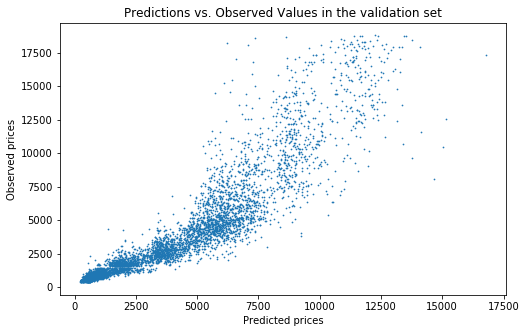

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x=predictions, y=y_val, s=0.5)
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices')
ax.set_title("Predictions vs. Observed Values in the validation set");

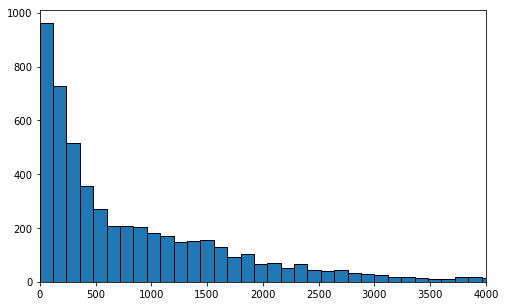

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(abs(y_val-predictions), bins=100, edgecolor='black')
ax.set_xlim(0, 4e3);